# 0.6 PyTorch Transfer Learning

What is transfer learning?

Transfer learning involves taking the parameters of what one model has learned on another dataset and applying

* Pretrained model=foundation models

Link: https://pytorch.org/vision/stable/models.html

In [ ]:
import torch
import torchvision

print(torch.__version__)#want 1.12+
print(torchvision.__version__)#want 0.13+

2.3.0+cu121
0.18.0+cu121


Now that we got the versions we want for torch and torchvision, let's import the code we've writteen in previous sections so that we dont' have to write it again.

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 20.56 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [ ]:
device="cpu" if torch.cuda.is_available() else "cpu"
device
#device agnostic code

'cpu'

In [ ]:
import os
import zipfile

from pathlib import Path
import requests

#setup data path
data_path=Path("data/")
image_path=data_path/"pizza_steak_sushi" #images from a subset of classes from the

#if the image folder doesn't exist, download it and prepare it
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    #downlaod images in zipfolder
    with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
        request=requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("dONKloading pizza,sushi,steak data..")
        f.write(request.content)

        #unzip
        with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
          print("unzipping data")
          zip_ref.extractall(image_path)


    #remose zip file
    os.remove(data_path/"pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi directory, creating one...
dONKloading pizza,sushi,steak data..
unzipping data


In [ ]:
#setup directories
train_dir=image_path/"train"
test_dir=image_path/"test"

## 2. Create Datasets and Dataloaders

Now we've got some data, turn it into PyTorch DataLoaders.

We can use `data_setup.py` and `create_dataloader()` from the going_modular directory we made in 05.

One thing we think about when loading data is: how to **trainsform** it?

and with `torchvision` 0.13+ there's two ways to define it:

1. Manually created transforms-define what trainsfrom you want the data to go through
2. Automatically created transforms-transforms for the data are defined by the model we'd like to use.

Important point: when using a pretrained model, it's important that the data (including the custom data) that we pass through it is **transformed** in the same way the data model was trained on.

### 2.1 Creating a transform for `torchvision.models` (manual creation)

`torchvision.models` contains pretrained models(models ready for transfer learning) right within `torchvision`.

>All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize:
>
>

In [ ]:
from torchvision import transforms
normalize=transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])

manual_transforms=transforms.Compose([
    transforms.Resize((224,224)), #resize image to 224,224
    transforms.ToTensor(), #get image into range [0,1]
    normalize #get images into same distribution as ImageNet( where our pretrained models have been trained )
])

In [ ]:
from going_modular.going_modular import data_setup
train_dataloader, test_dataloader, class_names=data_setup.create_dataloaders(train_dir=train_dir,
                                                                        test_dir=test_dir,
                                                                        transform=manual_transforms,
                                                                        batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7846d1122e30>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models` (auto creation)

As of `torchvision` v0.13+ there is now support for automatic data transform creation based on the pretrained model weights you're using.'

In [ ]:
#get a set of pretrained model weights
weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT #DEFAULT = best available weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
# Get the transforms used to create our pretrained weights
auto_transforms=weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
#create dataloaders using automatic transforms
train_dataloader, test_dataloader, class_names=data_setup.create_dataloaders(train_dir=train_dir,
                                                                        test_dir=test_dir,
                                                                             transform=auto_transforms,
                                                                        batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7846d12aadd0>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

There are various places to get a pretrained model such as:

1. PyTorch domain libraries
2. Libraries like `timm` (torch image models)
3. HuggingFace hub (for plenty of different models)
4. Paperswithcode (for models across different problem spaces/domains)

### 3.1 Which pretrained model should you use?

*Experiment, experiment, experiment*

The whole idea of transfer learning: take an already well-performing model from a problem space similar to your own and then customize to your own problem

Three things to consider:
1. Speed - how fast does it run?
2. Size - how big is the model?
3. Performance - how well does it go on your chosen problem (e.g how well does it classify food images? for FoodVisoion Mini)?

Where does the model live?

Is it on a device (like a self-driving car)?

Or does it live on a server?

Looking at: https://pytorch.org/vision/stable/models.html#table-of-all-available-classification-weights

Which model should be chosen?

For our case it looks like EffNetB0 is one of our best optins in terms of performance vs size.

However, in light of The Bitter Lesson, if we had infinite compute, we'd likely pick the biggest model + most parameters + most general we could - http://www.incompleteideas.net/IncIdeas/BitterLesson.html

### 3.2 Setting up a pretrained model

Want to create an instance of pretrained `EffNetB0`-https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.EfficientNet_B0_Weights

In [ ]:
# OLD method of creating a pretrained model (prior to torchvision v0.13)
#model=torchvision.model.efficientnet_b0(pretrained=True)

#New method of creating a pretrained model
weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
model=torchvision.models.efficientnet_b0(weights=weights)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 138MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
#model.features
#model.avgpool
model.classifier # out features=1000 but for our model we only need 3

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary of our model with `torchinfo.summary()`

In [ ]:
#print with torchinfo
from torchinfo import summary
summary(model, input_size=(1,3,224,224), #example of [batch_size, color_channels, height, width]
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and changing the output layer to suit our needs

With a feature extractor model ,typically you will "freeze" the base layers of a pretrained/foundation model and updatge the output layers to suit your own problems.

In [ ]:
#model.features
#freeze all the base layers in EffNetB0
for param in model.features.parameters():
    #print(param)
    param.requires_grad=False

In [ ]:
#update classifier head of our model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Dropout - https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html
model.classifier=nn.Sequential(
    nn.Dropout(p=0.3), #see data scient cheatsheet for visual display of dropout
    nn.Linear(in_features=1280, #feature vector coming in
              out_features=len(class_names))).to(device) #how many classes do we have

model.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=False)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [ ]:
summary(model, input_size=(1,3,224,224), #example of [batch_size, color_channels, height, width]
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train model

In [ ]:
#Define a loss and an optimizer
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model.parameters(), lr=0.001)

In [ ]:
#import train function
from going_modular.going_modular import engine

#set seeeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#timer
from timeit import default_timer as timer
start_timer=timer()

#setup training and save results
results=engine.train(model=model,
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=5,
                    device=device)

#end timer and print out how long it too
end_time=timer()

print(f"[INFO] Total traing time: {end_time-start_timer:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1050 | train_acc: 0.3555 | test_loss: 0.8914 | test_acc: 0.6619
Epoch: 2 | train_loss: 0.9205 | train_acc: 0.6719 | test_loss: 0.8043 | test_acc: 0.7955
Epoch: 3 | train_loss: 0.7651 | train_acc: 0.8516 | test_loss: 0.6681 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.7388 | train_acc: 0.6875 | test_loss: 0.6120 | test_acc: 0.8958
Epoch: 5 | train_loss: 0.6325 | train_acc: 0.7539 | test_loss: 0.6165 | test_acc: 0.9072
[INFO] Total traing time: 169.762 seconds


## 5. Evaluate the model by plotting loss curves

[INFO] Couldn't find helper functions.py, downloading...


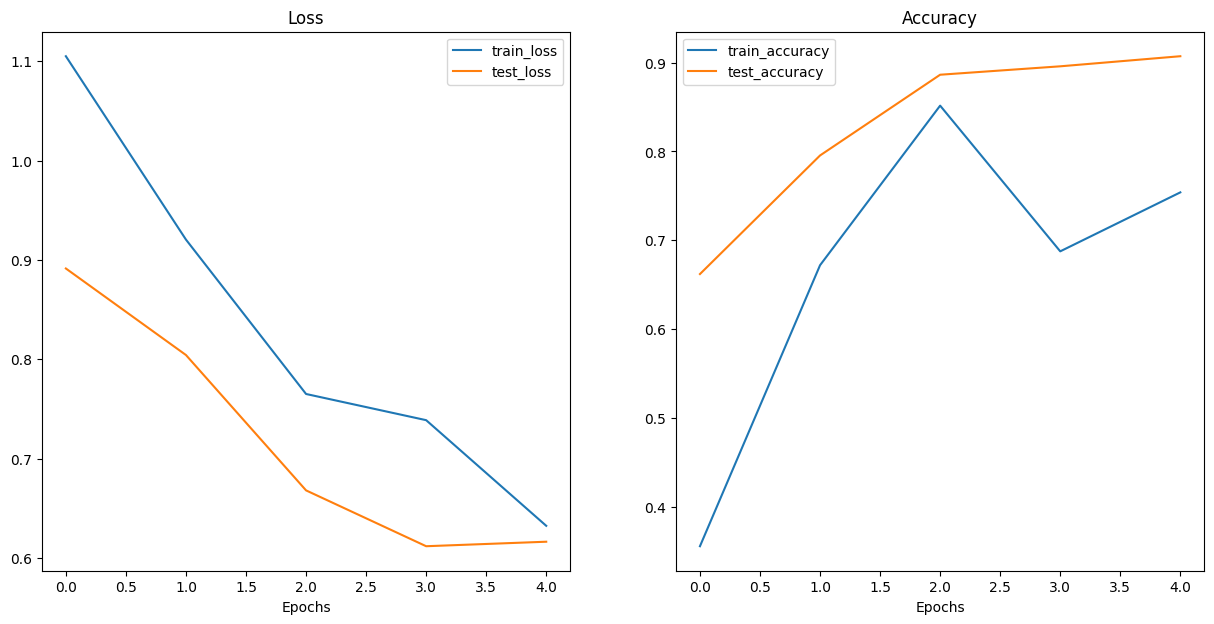

In [ ]:
try:
  from helper_functions import plot_loss_curves
  print("failed")
except:
  print(f"[INFO] Couldn't find helper functions.py, downloading...")
  with open("helper_functions.py", "wb") as f:
    import requests
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves

#plot the loss curves of our model
plot_loss_curves(results)

What do out loss curves look like compared to the ideal loss curves?

See here for more: https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like

## 6. Make predictions on images from the test set

Let's adhere to the motto: *visualise, visualise, visualise*1

And make some qualitative predictions on our test set.

Some things to keep in mind when maing predictions/inference on test data/custom data.

We have to make sure that our test/custom data is:
* Same shape - images need to be same shape as model trained on
* Same datatype-custom data should be in the data data type
* Same device- custom data/test should be on the samel device
* Same transforms - if you've trnaformed your custom data, ideally you will transform the test data the same

To do all of this automatically, let's create a function called `pred_and_plot_image()`:

The function will be similar to the one here: https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device
2. OPen the image with `PIL.Image.Open()`
3. Create a transform if one diesn't exist
4. Make sure the model is on the target device
5. Turn the model to `model.eval()` mode to make sure it's ready for inference (this will turn off things like `nn.Dropout()`)
6. Transform the target image and make sure its dimensionality is suited for the model (this mainly relates to batch size)
7. Make prediction on the image by passing to the model
8. Convert the model's output logits to prediction probabilities using `torch.softmax()`
9. Convert model's prediction probabilities to prediction labels using `torch.argmax()`
10. Plot the image with `matplotlib` and set the title to the prediction label from step 9 and prediction probability from step 8

In [ ]:
from typing import List, Tuple

from PIL import Image

from torchvision import transforms

#1. Take a trained model
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        image_size: Tuple[str,str]=(224,224),
                        transform:torchvision.transforms=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 2. Open image with PIL
    img = Image.open(image_path)

    # 3. Create transform if one doesn't exist
    if transform is not None:
        image_transform = transform
    else:
      image_transform=transforms.Compose([
          transforms.Resize(image_size),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])])

    ####Predict on Image###
    #4. Make sure model is to target device
    model.to(device)

    #Turn on inference mode and eval mode
    model.eval()
    with torch.inference_mode():
      #5. Transform the target image and make sure its dimensionality is suited for the model
        transformed_image = image_transform(img).unsqueeze(dim=0) #batch size dimension needed when dealing with singular images


    #6. Make prediction on the transformed image with the target device
        target_image_pred = model(transformed_image.to(device))

    #7. Convert the model's output logits to pred probs
        target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 8. Convert the model's pred probs to pred labels
        target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.figure()
    plt.imshow(img) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

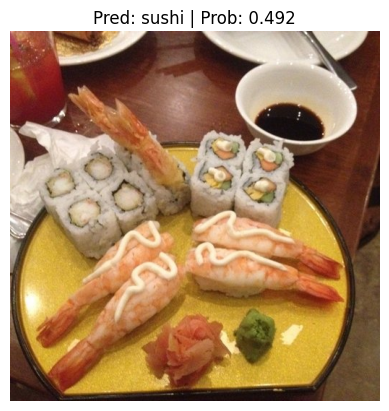

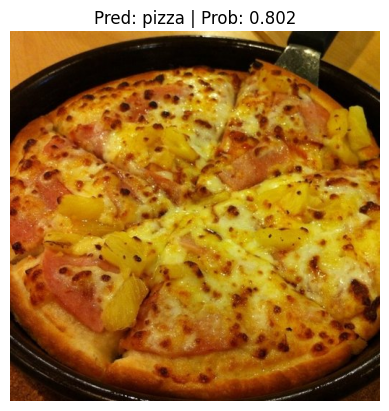

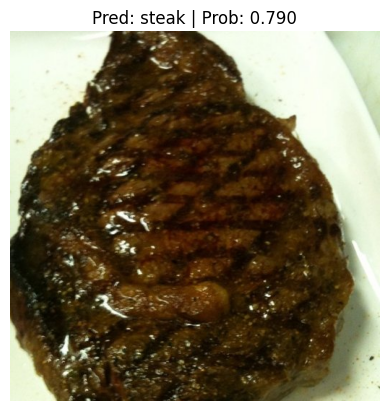

In [ ]:
#Get random list of image paths from the test set
import random
num_plot_images=3
test_image_path_list=list(test_dir.glob("*/*.jpg"))
random_image_path=random.sample(test_image_path_list, num_plot_images)
#random_image_path

#Make predictions and plot image
for image_path in random_image_path:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224,224),
                        device=device)

### 6.1 Making a prediction on a custom image

Let;s make a prediction on the pizza dad image from: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg

In [ ]:
#Download the image
import requests

#setup custom image path
custom_image_path=data_path/"04-pizza-dad.jpeg"

#Download the image if it doesn't exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
      #download from raw github link]
      request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
      print(f"Downloading to {custom_image_path}")
      f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping donwload...")

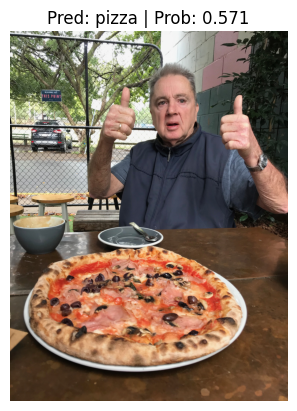

In [ ]:
pred_and_plot_image(model=model,
                        image_path=custom_image_path,
                        class_names=class_names,
                        image_size=(224,224),
                        device=device)

## Exercises

See here: https://www.learnpytorch.io/06_pytorch_transfer_learning/#exercises

####Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels

In [ ]:
#import important libraries
import torch
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets


#try to install torch info
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

#try to import going modular functions from github

try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/jjandmoreletters/JJ-s-Code
    !mv JJ-s-Code/going_modular .
    !rm -rf JJ-s-Code
    from going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'JJ-s-Code'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (168/168), done.
remote: Total 185 (delta 51), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (185/185), 18.55 MiB | 10.48 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
import os
import requests
import zipfile
from pathlib import Path

#set up pathing
data_path=Path("data")
image_path=data_path/"pizza_steak_sushi"

#if image folder doesn't exist
if image_path.is_dir():
  print(f"{image_path} already exists, skipping download...")
else:
  print(f"Creating {image_path}")
  image_path.mkdir(parents=True,exist_ok=True)

  #Download pizza steak sushi zip file from github
  with open( data_path/"pizza_steak_sushi.zip", "wb") as f:
    request=requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print(f"Downloading {data_path/'pizza_steak_sushi.zip'}")
    f.write(request.content)

  #unzip pizza, steak, sushi data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
      print("Unzipping pizza, steak, sushi data...")
      zip_ref.extractall(image_path)

    # Remove .zip file
  os.remove(data_path / "pizza_steak_sushi.zip")


#setup directories
train_dir=image_path/"train"
test_dir=image_path/"test"

Creating data/pizza_steak_sushi
Unzipping pizza, steak, sushi data...


In [ ]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

train_dataloader, test_dataloader, class_names=data_setup.create_dataloaders(train_dir=train_dir,
                                                                        test_dir=test_dir,
                                                                        transform=simple_transform,
                                                                        batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7a029640bc70>,
 ['pizza', 'steak', 'sushi'])

#### Get and prepare a pretrained model

In [ ]:
# setup model with pretrained wieghts
weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_0=torchvision.models.efficientnet_b0(weights=weights)
model_0

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:01<00:00, 21.2MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape=len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [ ]:
#print with torchinfo
from torchinfo import summary
summary(model_0, input_size=(1,3,224,224), #example of [batch_size, color_channels, height, width]
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1033 | train_acc: 0.3789 | test_loss: 0.8906 | test_acc: 0.5701
Epoch: 2 | train_loss: 0.9392 | train_acc: 0.6445 | test_loss: 0.8079 | test_acc: 0.7027
Epoch: 3 | train_loss: 0.7611 | train_acc: 0.8945 | test_loss: 0.6431 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.7602 | train_acc: 0.6992 | test_loss: 0.5840 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.6309 | train_acc: 0.8867 | test_loss: 0.6012 | test_acc: 0.9072
[INFO] Total training time: 169.685 seconds


####Make predictions on the entire test dataset with the model

In [ ]:
from tqdm.auto import tqdm

# Make predictions on the entire test dataset
test_preds = []
model_0.eval()
with torch.inference_mode():
  # Loop through the batches in the test dataloader
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    # Pass the data through the model
    test_logits = model_0(X)

    # Convert the pred logits to pred probs
    pred_probs = torch.softmax(test_logits, dim=1)

    # Convert the pred probs into pred labels
    pred_labels = torch.argmax(pred_probs, dim=1)

    # Add the pred labels to test preds list
    test_preds.append(pred_labels)

# Concatenate the test preds and put them on the CPU
test_preds = torch.cat(test_preds).to(device)
test_preds

  0%|          | 0/3 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2])

####Make a confusion matrix with the test preds and the truth labels

In [ ]:
# Get the truth labels for test dataset
test_truth = torch.cat([y for X, y in test_dataloader])
test_truth

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a0344f031c0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a0344f031c0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
if w.is_alive():    
if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only te

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])

In [ ]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 42.3 MB/s eta 0:00:00
mlxtend version: 0.23.1


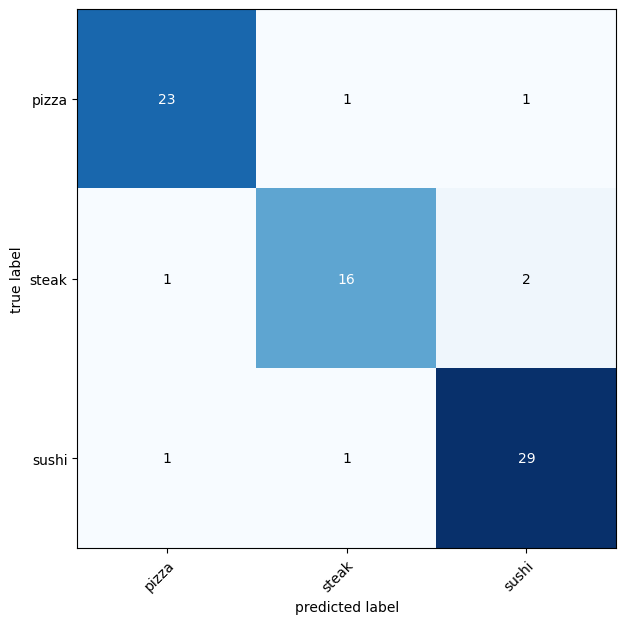

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix instance
confmat = ConfusionMatrix(task="multiclass",num_classes=len(class_names))
confmat_tensor = confmat(preds=test_preds,
                         target=test_truth)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names,
    figsize=(10, 7)
)

####Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images

Want to:

    Create a DataFrame with sample, label, prediction, pred prob
    Sort DataFrame by correct (does label == prediction)
    Sort DataFrame by pred prob (descending)
    Plot the top 5 "most wrong"


In [ ]:
from pathlib import Path

test_data_paths=list(Path(test_dir).glob("*/*.jpg"))
test_labels=[path.parent.stem for path in test_data_paths]

def pred_and_store(test_paths, model, transform, class_names, device):
  test_pred_list=[]
  for path in tqdm(test_paths):
    #create empty dict
    pred_dict={}

    #o
    #get sample path
    pred_dict["image_path"]=path

    #get class name
    class_name=path.parent.stem
    pred_dict["class_name"]=class_name

    #prediction and prediction prob
    from PIL import Image
    img=Image.open(path)
    img_transform=transform(img).unsqueeze(dim=0) #add batch dimension
    model.eval()
    with torch.inference_mode():
      pred_logits=model(img_transform.to(device))
      pred_probs=torch.softmax(pred_logits, dim=1)
      pred_label=torch.argmax(pred_probs, dim=1)
      pred_class=class_names[pred_label.to(device)]

      #make sure things in the dictionary ar on the device

      pred_dict["pred_class"]=pred_class
      pred_dict["pred_prob"]=pred_probs.unsqueeze(0).max().cpu().item()

      #does label match prediction
      pred_dict["correct"]=pred_dict["class_name"]==pred_dict["pred_class"]
      #add dictionary to list of pred
      test_pred_list.append(pred_dict)

  return test_pred_list

In [ ]:
test_pred_dicts=pred_and_store(test_paths=test_data_paths,
                                model=model_0,
                                transform=simple_transform,
                                class_names=class_names,
                                device=device)

test_pred_dicts[:50]

  0%|          | 0/75 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/pizza_steak_sushi/test/steak/1285886.jpg'),
  'class_name': 'steak',
  'pred_class': 'sushi',
  'pred_prob': 0.4244355261325836,
  'correct': False},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/690177.jpg'),
  'class_name': 'steak',
  'pred_class': 'steak',
  'pred_prob': 0.6454727649688721,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/502076.jpg'),
  'class_name': 'steak',
  'pred_class': 'steak',
  'pred_prob': 0.7672944068908691,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/1302563.jpg'),
  'class_name': 'steak',
  'pred_class': 'steak',
  'pred_prob': 0.7834222912788391,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
  'class_name': 'steak',
  'pred_class': 'steak',
  'pred_prob': 0.7404564619064331,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/3873283.jpg'),
  'class_name': 'stea

In [ ]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_dicts)
# Sort DataFrame by correct then by pred_prob
top_5_most_wrong = test_pred_df.sort_values(by=["correct", "pred_prob"], ascending=[True, False]).head()
top_5_most_wrong

image_path class_name pred_class  \
65   data/pizza_steak_sushi/test/sushi/684266.jpg      sushi      steak   
0   data/pizza_steak_sushi/test/steak/1285886.jpg      steak      sushi   
41  data/pizza_steak_sushi/test/pizza/2508636.jpg      pizza      steak   
51   data/pizza_steak_sushi/test/sushi/175783.jpg      sushi      pizza   
12  data/pizza_steak_sushi/test/steak/1627703.jpg      steak      sushi   

    pred_prob  correct  
65   0.504828    False  
0    0.424436    False  
41   0.420366    False  
51   0.390239    False  
12   0.388568    False

In [ ]:
top_5_most_wrong.dtypes

image_path     object
class_name     object
pred_class     object
pred_prob     float64
correct          bool
dtype: object

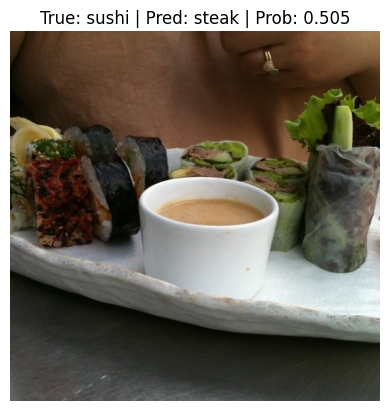

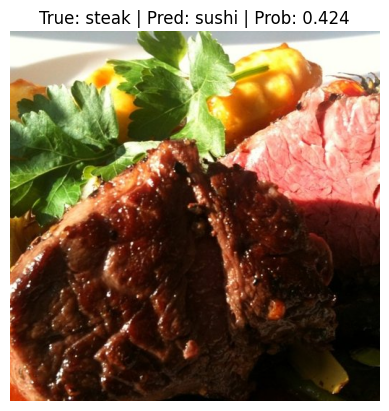

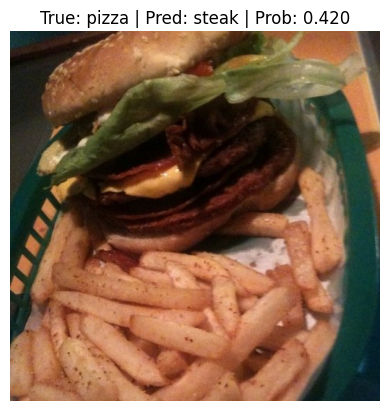

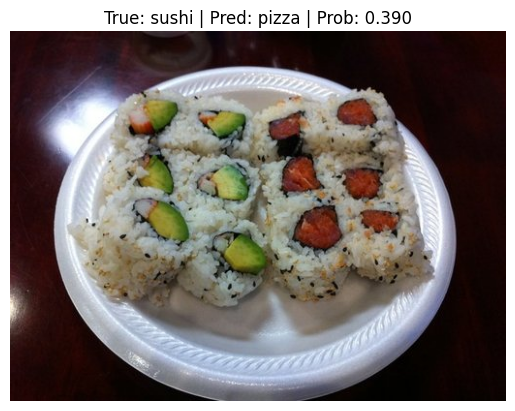

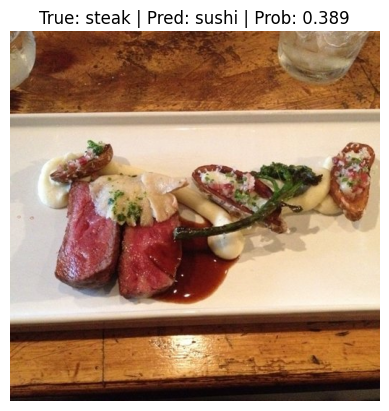

In [ ]:
import torchvision
import matplotlib.pyplot as plt
# Plot the top 5 most wrong images
for row in top_5_most_wrong.iterrows():
  row = row[1]
  image_path = row[0]
  true_label = row[1]
  pred_prob = row[3]
  pred_class = row[2]
  # Plot the image and various details
  img = torchvision.io.read_image(str(image_path)) # get image as tensor
  plt.figure()
  plt.imshow(img.permute(1, 2, 0)) # matplotlib likes images in [height, width, color_channels]
  plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob:.3f}")
  plt.axis(False)

####Predict on own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?

--2024-06-29 14:12:40--  https://images.unsplash.com/photo-1588315029754-2dd089d39a1a
Resolving images.unsplash.com (images.unsplash.com)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to images.unsplash.com (images.unsplash.com)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3208960 (3.1M) [image/jpeg]
Saving to: ‘photo-1588315029754-2dd089d39a1a’

photo-1588315029754 100%[===================>]   3.06M  --.-KB/s    in 0.1s    

2024-06-29 14:12:40 (26.0 MB/s) - ‘photo-1588315029754-2dd089d39a1a’ saved [3208960/3208960]



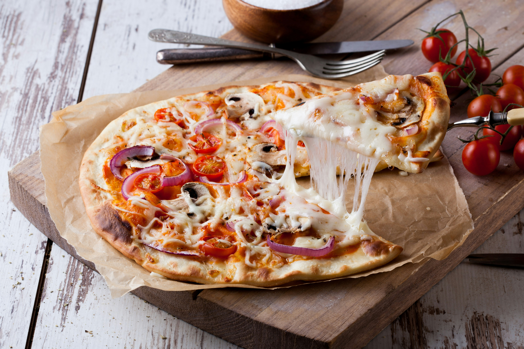

In [ ]:
# Get an image of pizza/steak/sushi
!wget https://images.unsplash.com/photo-1588315029754-2dd089d39a1a
!cp photo-1588315029754-2dd089d39a1a pizza.jpg

from PIL import Image

with Image.open("pizza.jpg") as img:
  # Reduce the image size and width by 10
  (width, height) = (img.width // 10, img.height // 10)
  img_resized = img.resize((width, height))

img_resized

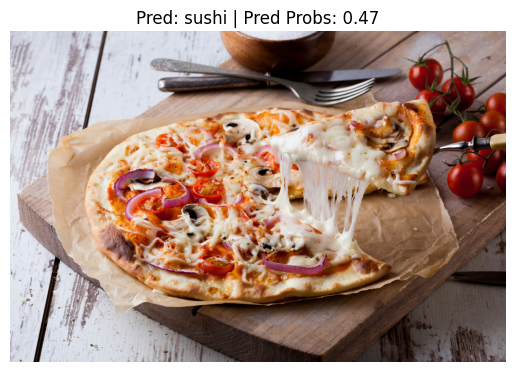

In [ ]:

# Make a function to pred and plot images
def pred_and_plot(image_path, model, transform, class_names, device=device):
  # open image
  image = Image.open(image_path)

  # transform image
  transformed_image = transform(image)

  # pred on image
  model.eval()
  with torch.inference_mode():
    pred_logit = model(transformed_image.unsqueeze(0).to(device))
    pred_probs=torch.softmax(pred_logit, dim=1)
    pred_label = torch.argmax(torch.softmax(pred_logit, dim=1), dim=1)

  # plot image and pred
  plt.figure()
  plt.imshow(image)
  plt.title(f"Pred: {class_names[pred_label]} | Pred Probs: {pred_probs.max().item():.2f}")
  plt.axis(False);

pred_and_plot(image_path="pizza.jpg",
              model=model_0,
              transform=simple_transform,
              class_names=class_names)

--2024-06-29 14:16:35--  https://images.unsplash.com/photo-1546964124-0cce460f38ef
Resolving images.unsplash.com (images.unsplash.com)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to images.unsplash.com (images.unsplash.com)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3617320 (3.4M) [image/jpeg]
Saving to: ‘photo-1546964124-0cce460f38ef’

photo-1546964124-0c 100%[===================>]   3.45M  --.-KB/s    in 0.1s    

2024-06-29 14:16:35 (33.5 MB/s) - ‘photo-1546964124-0cce460f38ef’ saved [3617320/3617320]



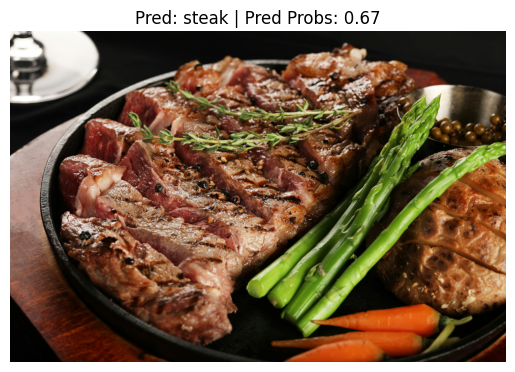

In [ ]:
# Try again on a photo of steak from unsplash.com
!wget https://images.unsplash.com/photo-1546964124-0cce460f38ef
!cp photo-1546964124-0cce460f38ef steak.jpg

pred_and_plot("steak.jpg",
              model=model_0,
              transform=simple_transform,
              class_names=class_names)

--2024-06-29 14:16:55--  https://images.unsplash.com/photo-1570913149827-d2ac84ab3f9a
Resolving images.unsplash.com (images.unsplash.com)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to images.unsplash.com (images.unsplash.com)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2006529 (1.9M) [image/jpeg]
Saving to: ‘photo-1570913149827-d2ac84ab3f9a’

photo-1570913149827 100%[===================>]   1.91M  --.-KB/s    in 0.1s    

2024-06-29 14:16:55 (15.5 MB/s) - ‘photo-1570913149827-d2ac84ab3f9a’ saved [2006529/2006529]



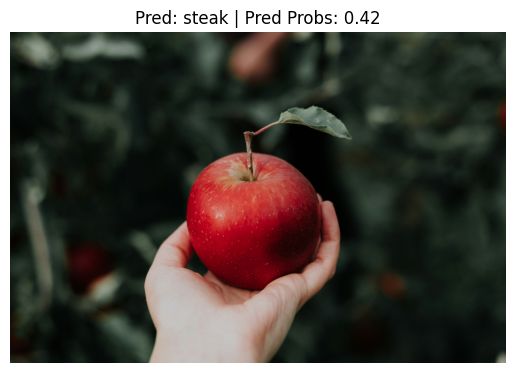

In [ ]:

# Get an image of not pizza/steak/sushi
!wget https://images.unsplash.com/photo-1570913149827-d2ac84ab3f9a
!cp photo-1570913149827-d2ac84ab3f9a apple.jpg

pred_and_plot(image_path="apple.jpg",
              model=model_0,
              transform=simple_transform,
              class_names=class_names)

#### Train the model from section 4 above for longer (10 epochs should do), what happens to the performance?

In [ ]:
# Instantiate a new model
import torchvision
from torch import nn
model_1 = torchvision.models.efficientnet_b0(pretrained=True).to(device)

# Freeze the base layers
for param in model_1.features.parameters():
  param.requires_grad = False

# Change the classification head
torch.manual_seed(42)
model_1.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)

# d
# f

summary(model_1,
        input_size=[32, 3, 224, 224],
        col_names=["input_size", "output_size", "trainable"])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                                  Input Shape               Output Shape              Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 3]                   Partial
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1280, 7, 7]          False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 32, 112, 112]        False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 32, 112, 112]        False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        [32, 32, 112, 112]        False
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 32, 112, 112]        [32, 16, 112, 112]        False
│    │    └─MBConv: 3-4                                 [32, 32, 112, 112]        [32

In [ ]:

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Create loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

# Setup training and save the results
model_1_results = engine.train(model=model_1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1033 | train_acc: 0.3789 | test_loss: 0.8906 | test_acc: 0.5701
Epoch: 2 | train_loss: 0.9392 | train_acc: 0.6445 | test_loss: 0.8079 | test_acc: 0.7027
Epoch: 3 | train_loss: 0.7611 | train_acc: 0.8945 | test_loss: 0.6431 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.7602 | train_acc: 0.6992 | test_loss: 0.5840 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.6309 | train_acc: 0.8867 | test_loss: 0.6012 | test_acc: 0.9072
Epoch: 6 | train_loss: 0.5914 | train_acc: 0.7969 | test_loss: 0.5537 | test_acc: 0.8968
Epoch: 7 | train_loss: 0.5783 | train_acc: 0.8086 | test_loss: 0.5753 | test_acc: 0.8665
Epoch: 8 | train_loss: 0.5109 | train_acc: 0.7930 | test_loss: 0.4982 | test_acc: 0.8968
Epoch: 9 | train_loss: 0.4713 | train_acc: 0.9297 | test_loss: 0.5072 | test_acc: 0.9072
Epoch: 10 | train_loss: 0.5388 | train_acc: 0.8047 | test_loss: 0.5333 | test_acc: 0.9176
[INFO] Total training time: 379.021 seconds


[INFO] Couldn't find helper_functions.py, downloading...


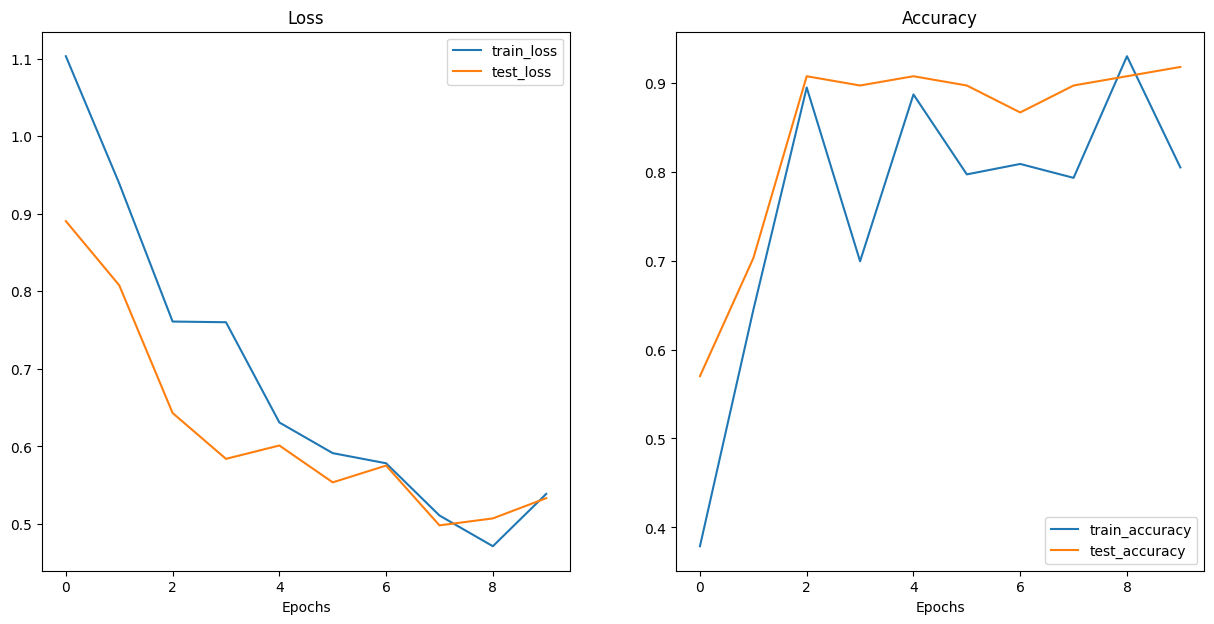

In [ ]:

# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

plot_loss_curves(model_1_results)

####Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images

In [ ]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [ ]:


# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])


# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names



(<torch.utils.data.dataloader.DataLoader at 0x7a026c4d4d90>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
##Get another pretrained model


# Create a new model for 20 percent of the data
model_2 = torchvision.models.efficientnet_b0(pretrained=True).to(device)

# Freeze all the base layers
for param in model_2.features.parameters():
  param.requires_grad = False

# Change the classifier head
torch.manual_seed(42)
model_2.classifier = nn.Sequential(
  nn.Dropout(p=0.2, inplace=True),
  nn.Linear(in_features=1280, out_features=3, bias=True)
).to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_2_results = engine.train(model=model_2,
                              train_dataloader=train_dataloader_20_percent,
                              test_dataloader=test_dataloader_20_percent,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              epochs=7,
                              device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9913 | train_acc: 0.5521 | test_loss: 0.6565 | test_acc: 0.8915
Epoch: 2 | train_loss: 0.7156 | train_acc: 0.7937 | test_loss: 0.5414 | test_acc: 0.8943
Epoch: 3 | train_loss: 0.5648 | train_acc: 0.8521 | test_loss: 0.4511 | test_acc: 0.9006
Epoch: 4 | train_loss: 0.4661 | train_acc: 0.9042 | test_loss: 0.4053 | test_acc: 0.8915
Epoch: 5 | train_loss: 0.4526 | train_acc: 0.8708 | test_loss: 0.3743 | test_acc: 0.9006
Epoch: 6 | train_loss: 0.3895 | train_acc: 0.8771 | test_loss: 0.3449 | test_acc: 0.9131
Epoch: 7 | train_loss: 0.4137 | train_acc: 0.8750 | test_loss: 0.3315 | test_acc: 0.9131
[INFO] Total training time: 548.479 seconds


In [ ]:
# Check results with 10% of data for 5 epochs
max(model_0_results["test_acc"]), min(model_0_results["test_loss"])

(0.9071969696969697, 0.5839809576670328)

In [ ]:
# Check results with 20% of data for 5 epochs
max(model_2_results["test_acc"]), min(model_2_results["test_loss"])

(0.9130681818181818, 0.3315377742052078)

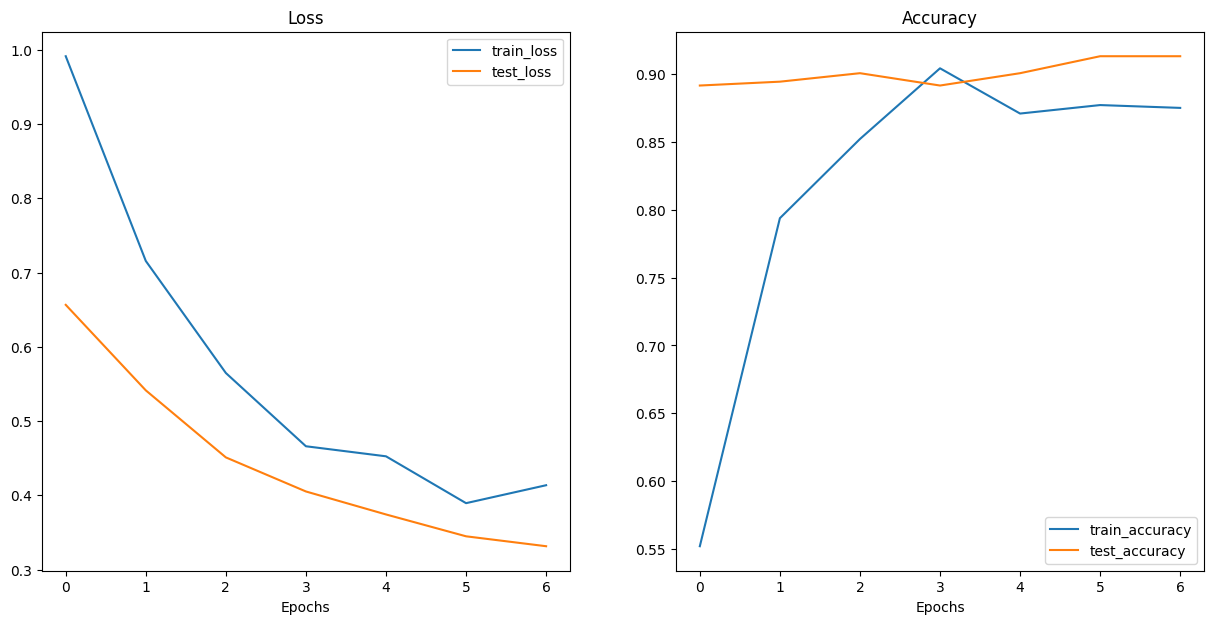

In [ ]:
plot_loss_curves(model_2_results)

####Try a different model from torchvision.models on the Pizza, Steak, Sushi data

In [ ]:
# Create a transform to transform the data
from torchvision import transforms, models
effnet_b2_transform = transforms.Compose([
  transforms.Resize((288, 288)), # effnet_b2 takes images of size 288, 288 - https://github.com/pytorch/vision/blob/d2bfd639e46e1c5dc3c177f889dc7750c8d137c7/references/classification/train.py#L92-L93
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# Import the data
train_dataloader_effnet_b2, test_dataloader_effnet_b2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                   test_dir=test_dir,
                                                                                                   transform=effnet_b2_transform,
                                                                                                   batch_size=32)


In [ ]:
# Create a effnet_b2 new model - https://pytorch.org/vision/stable/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2
model_3 = torchvision.models.efficientnet_b2(pretrained=True).to(device)

# Freeze the base layers
for param in model_3.parameters():
  param.requires_grad = False

# Change the classifier head (to suit our problem)
torch.manual_seed(42)
model_3.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=len(class_names), bias=True)
).to(device)

# Get a summary of the new model
# summary(model_3,
#         input_size=[32, 3, 288, 288],
#         col_names=["input_size", "output_size", "trainable"])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 135MB/s]


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_3_results = engine.train(model=model_3,
                              train_dataloader=train_dataloader_effnet_b2,
                              test_dataloader=test_dataloader_effnet_b2,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              epochs=5,
                              device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1039 | train_acc: 0.3477 | test_loss: 0.9379 | test_acc: 0.6307
Epoch: 2 | train_loss: 0.9083 | train_acc: 0.5898 | test_loss: 0.8722 | test_acc: 0.7841
Epoch: 3 | train_loss: 0.7391 | train_acc: 0.8633 | test_loss: 0.7607 | test_acc: 0.8769
Epoch: 4 | train_loss: 0.7964 | train_acc: 0.7227 | test_loss: 0.7237 | test_acc: 0.7955
Epoch: 5 | train_loss: 0.6825 | train_acc: 0.7695 | test_loss: 0.6749 | test_acc: 0.9280
[INFO] Total training time: 445.835 seconds


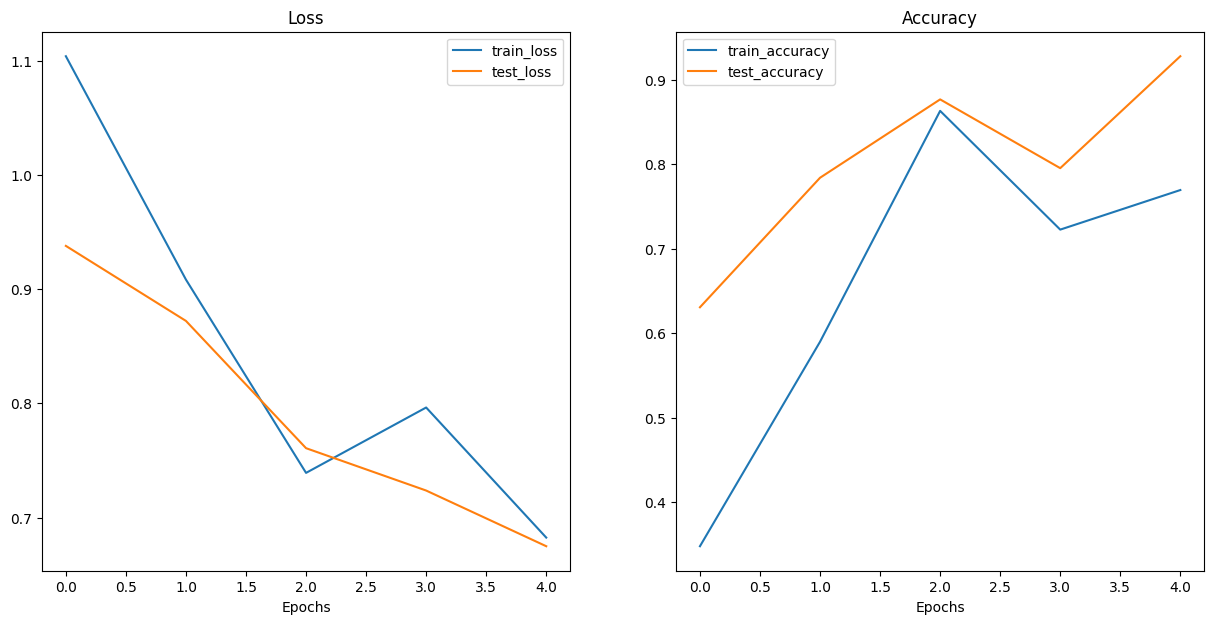

In [ ]:
plot_loss_curves(model_3_results)

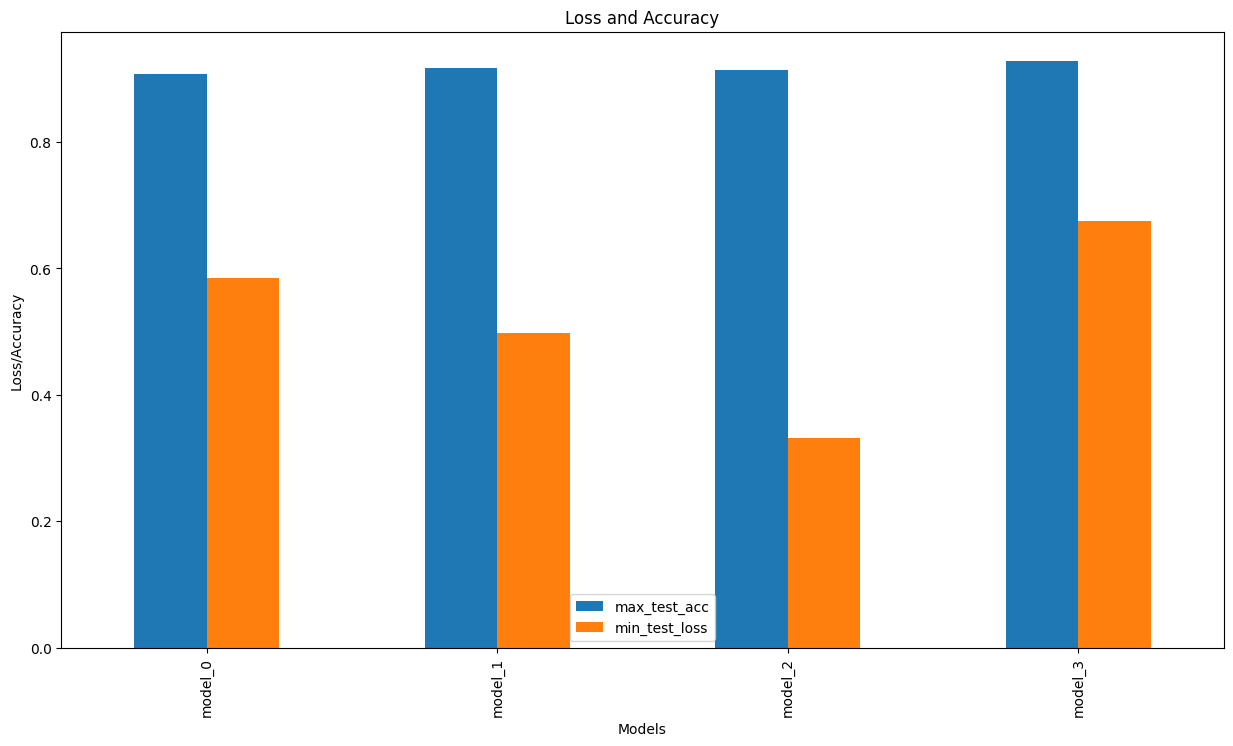

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# set width of bar
# barWidth = 0.25
# fig = plt.subplots(figsize =(12, 8))



import pandas as pd

plotdata = pd.DataFrame({

    "max_test_acc":[max(model_0_results["test_acc"]),max(model_1_results["test_acc"]),
                max(model_2_results["test_acc"]),max(model_3_results["test_acc"])],

    "min_test_loss":[min(model_0_results["test_loss"]),min(model_1_results["test_loss"])
                                                          ,min(model_2_results["test_loss"]),
                                                               min(model_3_results["test_loss"])]},

    index=["model_0", "model_1", "model_2", "model_3"])

plotdata.plot(kind="bar",figsize=(15, 8))

plt.title("Loss and Accuracy")
plt.xlabel("Models")
plt.ylabel("Loss/Accuracy")

plt.show()